In [1]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

In [2]:
# Use the following if you've placed advanced-timeseries-02427 inside another folder and are running the script from there
# Otherwise comment out

import sys
sys.path.append('..')

# 02427 Advanced Time Series Analysis
# Computer exercise 2

The main topic of this exercise is parameter estimation.

## Part 1

Estimate the parameters in at least one of the systems generating the time series that you simulated in part 1 of computer exercise 1. Use the prediction error method (also referred to as the conditional least squares method) for the estimation.

### Hints

See section 5.5 on page 115. Implement and minimize the loss function $Q_n(\theta)$ to estimate the parameters. As to make Part 2 feasible it is advisable to estimate two parameters and keep any remaining parameters fixed. **R:** Use for example the function `optim()` to do the minimization, see `?optim`. You have to give the function that is to be optimized as an argument. So make a function, which takes the parameters and returns the value of the loss function, like:

```R
RSSSetar <- function(theta)
{
  p1 <- theta[1]
  p2 <- theta[2]
  ## Calculate the objective function value
}
```

then give the initial values of $\theta$ and the function to `optim()`. **Matlab:** You may use `fminsearch`.

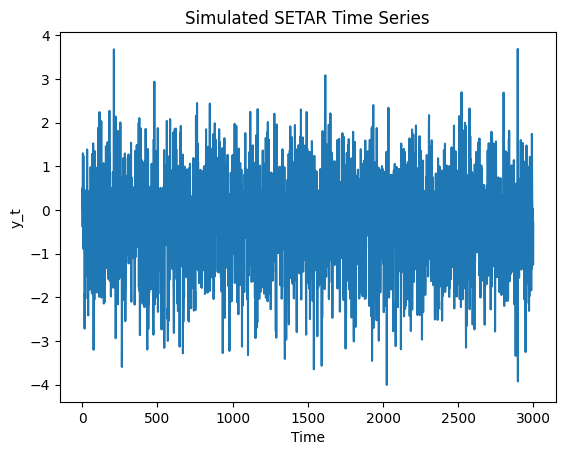

Estimated p1: 0.4739 (true: 0.5)
Estimated p2: -0.5013 (true: -0.5)
Minimized loss Q_n: 0.9741


In [3]:
# Simulate a time series from a SETAR model (as an example system from exercise 1)
n = 3000
p1_true = 0.5
p2_true = -0.5
r = 0.0  # Fixed threshold
sigma = 1.0

y = np.zeros(n)
for t in range(1, n):
    if y[t-1] <= r:
        y[t] = p1_true * y[t-1] + np.random.normal(0, sigma)
    else:
        y[t] = p2_true * y[t-1] + np.random.normal(0, sigma)

# Plot the simulated series
plt.plot(y)
plt.title('Simulated SETAR Time Series')
plt.xlabel('Time')
plt.ylabel('y_t')
plt.savefig('plots/simulated_setar_time_series.png')
plt.show()

# Define the loss function Q_n(theta)
def loss_setar(theta, y, r=0.0):
    p1, p2 = theta
    n = len(y)
    eps = np.zeros(n)
    for t in range(1, n):
        if y[t-1] <= r:
            eps[t] = y[t] - p1 * y[t-1]
        else:
            eps[t] = y[t] - p2 * y[t-1]
    return np.sum(eps[1:]**2) / (n - 1)

# Initial guess for parameters
theta_init = [0.0, 0.0]

# Minimize the loss function
result = minimize(loss_setar, theta_init, args=(y, r), method='Nelder-Mead')

p1_est, p2_est = result.x
print(f'Estimated p1: {p1_est:.4f} (true: {p1_true})')
print(f'Estimated p2: {p2_est:.4f} (true: {p2_true})')
print(f'Minimized loss Q_n: {result.fun:.4f}')

## Part 2

Use the model chosen in Part 1 and plot contour curves for the loss function for different values of the number of observations, $N$. Discuss your findings in the report.

### Hints

Chose two parameters $p_1$ and $p_2$ and calculate $Q_N(p_1, p_2)$ on a regular grid. Plot the contours of $Q_N(p_1, p_2)$ and repeat for subsets of different sizes, for example if 3000 steps were simulated plot contours based on:

```
1:3000
1:300
1:30
1001:1300
1001:1030
```

**R:** Use for example `filled.contour()`, which makes a contour plot with a key next to the plot. To change the colors, use `color.palette` as an argument, e.g. like:
`color.palette=colorRampPalette(c("#00007F","blue","#007FFF", "cyan","#7FFF7F","yellow","#FF7F00","red","#7F0000"))`

Another tip is to set the plot labels with `title()` and `expression()`, see `?plotmath`, e.g.:
`title(xlab=expression(a[1]), ylab=expression(a[2]), line=1.5)`

**Matlab:** Use `imagesc()` for contour plots.

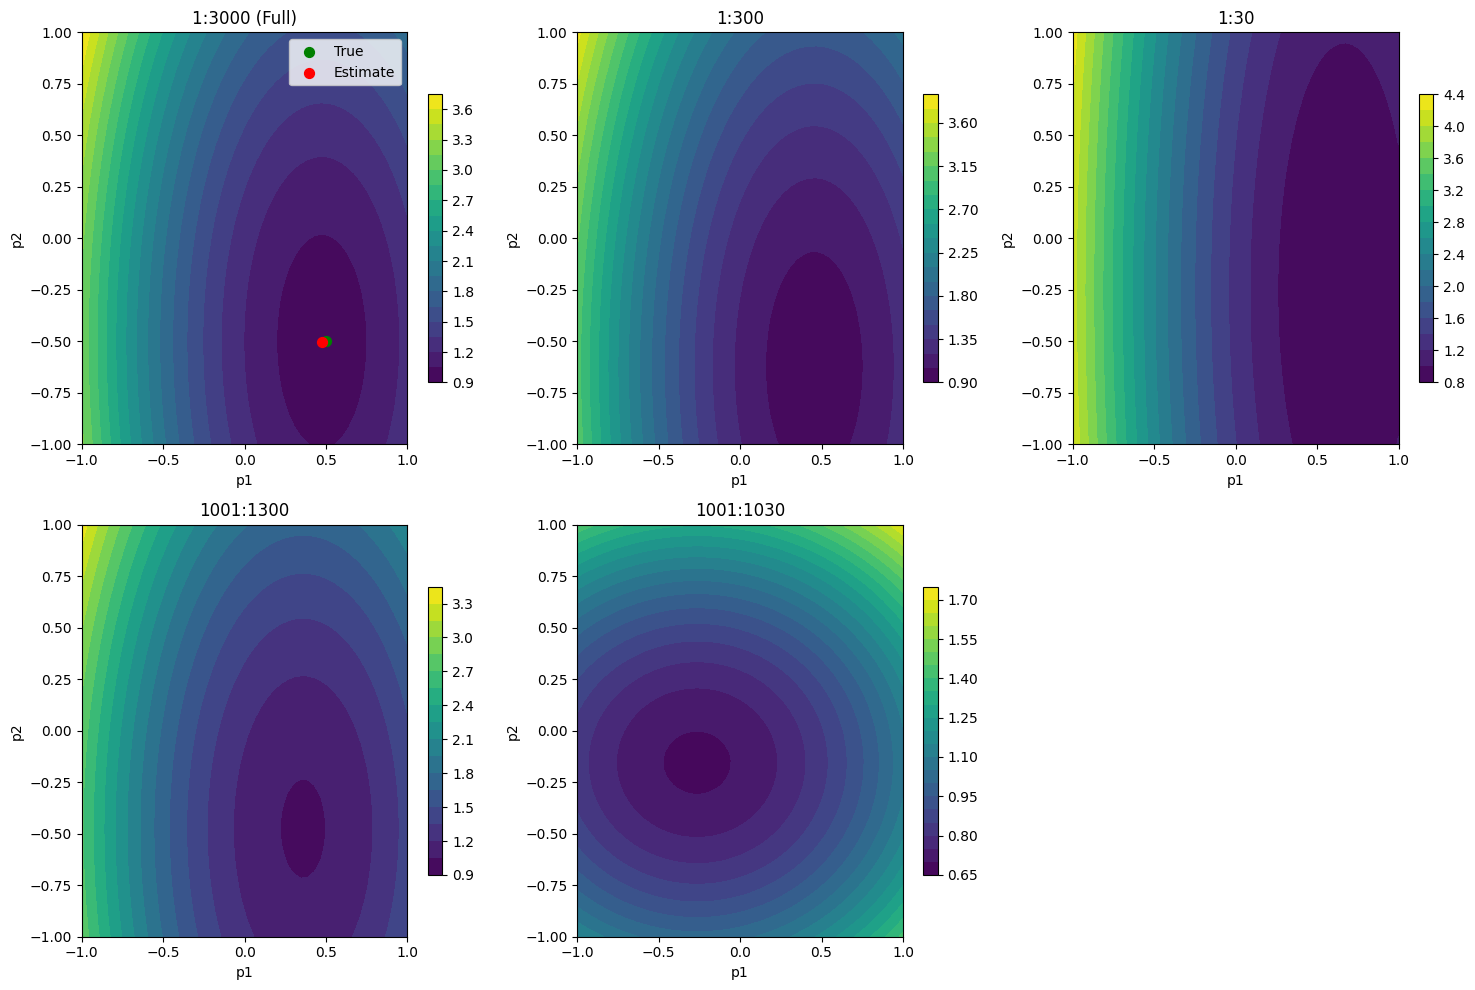

In [4]:
# Function to compute Q on a grid
def compute_Q_grid(y_sub, p1_range, p2_range, r=0.0):
    P1, P2 = np.meshgrid(p1_range, p2_range)
    Q = np.zeros(P1.shape)
    for i in range(P1.shape[0]):
        for j in range(P1.shape[1]):
            theta = [P1[i, j], P2[i, j]]
            Q[i, j] = loss_setar(theta, y_sub, r)
    return P1, P2, Q

# Define ranges for contours
p1_range = np.linspace(-1.0, 1.0, 50)
p2_range = np.linspace(-1.0, 1.0, 50)

# Subsets as specified
subsets = [
    (y[:3000], '1:3000 (Full)'),
    (y[:300], '1:300'),
    (y[:30], '1:30'),
    (y[1000:1300], '1001:1300'),
    (y[1000:1030], '1001:1030')
]

# Plot contours
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for idx, (y_sub, title_str) in enumerate(subsets):
    P1, P2, Q = compute_Q_grid(y_sub, p1_range, p2_range, r)
    cp = axs[idx].contourf(P1, P2, Q, levels=20, cmap='viridis')
    fig.colorbar(cp, ax=axs[idx], shrink=0.7)
    axs[idx].set_title(title_str)
    axs[idx].set_xlabel('p1')
    axs[idx].set_ylabel('p2')
    # Mark true and estimated for full data
    if 'Full' in title_str:
        axs[idx].scatter(p1_true, p2_true, color='green', s=50, label='True')
        axs[idx].scatter(p1_est, p2_est, color='red', s=50, label='Estimate')
        axs[idx].legend()

if len(axs) > len(subsets):
    axs[-1].remove()

plt.tight_layout()
plt.savefig('plots/setar_loss_surface_contours.png')
plt.show()

# Discussion: For larger N, the loss surface is sharper around the minimum, leading to more precise estimates. For small N or subsets, the surface is flatter, indicating higher uncertainty and potential bias in parameter estimates.

## Part 3

Chose a model for a doubly stochastic system. Write the model on state space form and simulate this model.

### Hints

Write the model on state-space form with math in the report. This is done by reparameterizing the model the same way as in the book on page 149. Implement and simulate, and comment on the results.

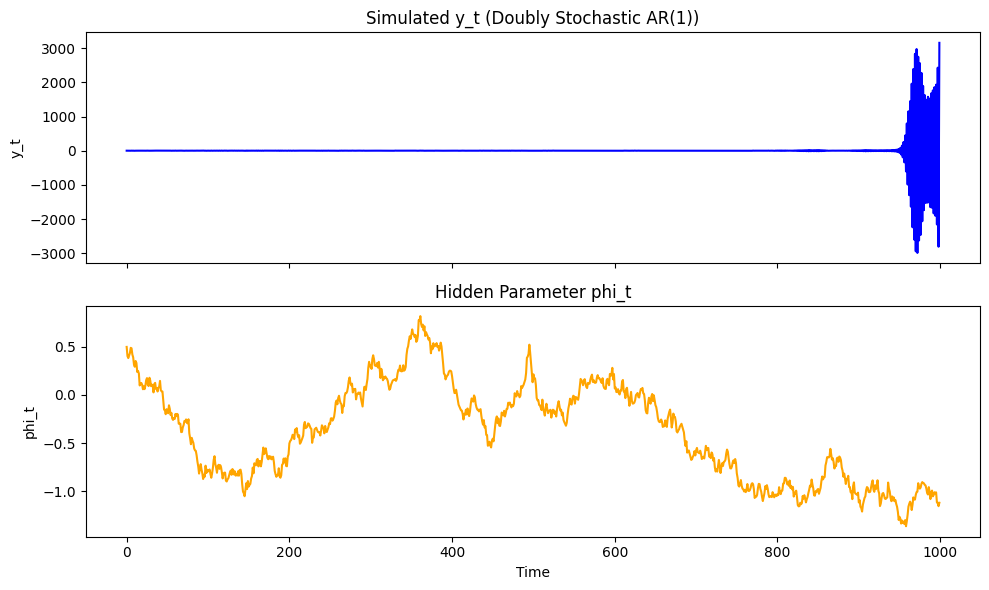

In [5]:
# Simulate a doubly stochastic system: random coefficient AR(1)
# y_t = phi_t * y_{t-1} + e_t, phi_t = phi_{t-1} + w_t
# State space form:
# State: phi_t
# Transition: phi_{t+1} = phi_t + w_t, w_t ~ N(0, sigma_w^2)
# Observation: y_t = phi_t * y_{t-1} + e_t, which is linear with time-varying H_t = y_{t-1}

n = 1000
phi0 = 0.5
sigma_w = 0.05  # Small variance for slow parameter drift
sigma_e = 1.0

phi = np.zeros(n)
y = np.zeros(n)
phi[0] = phi0
y[0] = np.random.normal(0, sigma_e)

for t in range(1, n):
    phi[t] = phi[t-1] + np.random.normal(0, sigma_w)
    y[t] = phi[t] * y[t-1] + np.random.normal(0, sigma_e)

# Plot the simulated series and hidden parameter
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.plot(y, color='blue')
ax1.set_title('Simulated y_t (Doubly Stochastic AR(1))')
ax1.set_ylabel('y_t')
ax2.plot(phi, color='orange')
ax2.set_title('Hidden Parameter phi_t')
ax2.set_xlabel('Time')
ax2.set_ylabel('phi_t')
plt.tight_layout()
plt.savefig('plots/simulated_doubly_stochastic_ar1.png')
plt.show()

# Comment: The model is on state space form with linear observation (time-varying H) and linear transition. The series y_t exhibits changing dynamics due to the stochastic evolution of phi_t.

## Part 4

The last part of this exercise concerns the Extended Kalman Filter (EKF).

### Introduction

First, consider the following simple state space model:
$$
\begin{aligned} x_{t+1} &= a x_t + v_t \\ y_t &= x_t + e_t \end{aligned} \quad (1)
$$
where $a$ is an unknown parameter and $v_t$ and $e_t$ are mutually uncorrelated white noise processes with variances $\sigma_v^2$ and $\sigma_e^2$ respectively.

Your task is to use an EKF to estimate $a$ by including it in the state vector, and study the implications of (erroneous) specifications of the variance $\sigma_v^2$ and initial values in the filter.

### Part 4a

Do a number of simulations (for example 20) of the model (Eq. 1) having $a = 0.4$ and the variances of the noise processes $\sigma_v^2 = \sigma_e^2 = 1$. Rewrite the model by including the parameter in the state vector, such that it can be used for parameter estimation with the EKF, as described on page 152 (Section 7.4) in the book.

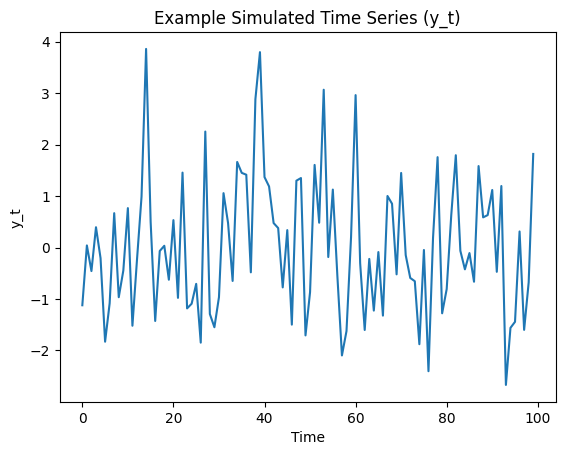

In [6]:
# True parameters
a_true = 0.4
sigma_v2_true = 1.0
sigma_e2_true = 1.0
n = 100  # Length of each time series
num_sim = 20

# Simulate 20 time series
simulations = []
for _ in range(num_sim):
    x = np.zeros(n)
    y = np.zeros(n)
    for t in range(1, n):
        x[t] = a_true * x[t-1] + np.random.normal(0, np.sqrt(sigma_v2_true))
    y = x + np.random.normal(0, np.sqrt(sigma_e2_true), n)
    simulations.append(y)

# Plot one example simulation
plt.plot(simulations[0])
plt.title('Example Simulated Time Series (y_t)')
plt.xlabel('Time')
plt.ylabel('y_t')
plt.savefig('plots/example_simulated_time_series.png')
plt.show()

# Rewritten model for EKF:
# Augmented state z_t = [x_t, a]^T
# Transition: z_{t+1} = f(z_t) + [v_t, 0]^T, where f(z_t) = [a * x_t, a]
# Observation: y_t = [1, 0] z_t + e_t
# The transition is nonlinear (product a * x_t), hence EKF is used with Jacobians.

### Part 4b

Do the following to draw some conclusion about the convergence properties for the EKF used:

Estimate the parameter $a$ in all of the simulations, with the initial value of $a$ set to $0.5$ and afterwards to $-0.5$. Plot the estimates and do this for the four combinations:

*   In the filter set $\sigma_v^2 = 10$ and initial value of the variance for the parameter $a$ to 1.
*   In the filter set $\sigma_v^2 = 1$ and initial value of the variance for the parameter $a$ to 1.
*   In the filter set $\sigma_v^2 = 10$ and initial value of the variance for the parameter $a$ to 10.
*   In the filter set $\sigma_v^2 = 1$ and initial value of the variance for the parameter $a$ to 10.

### Hints

**R:** The EKF is implemented in `EKF-example.R`.
**Matlab:** The EKF is implemented in `ekf_example.m`.

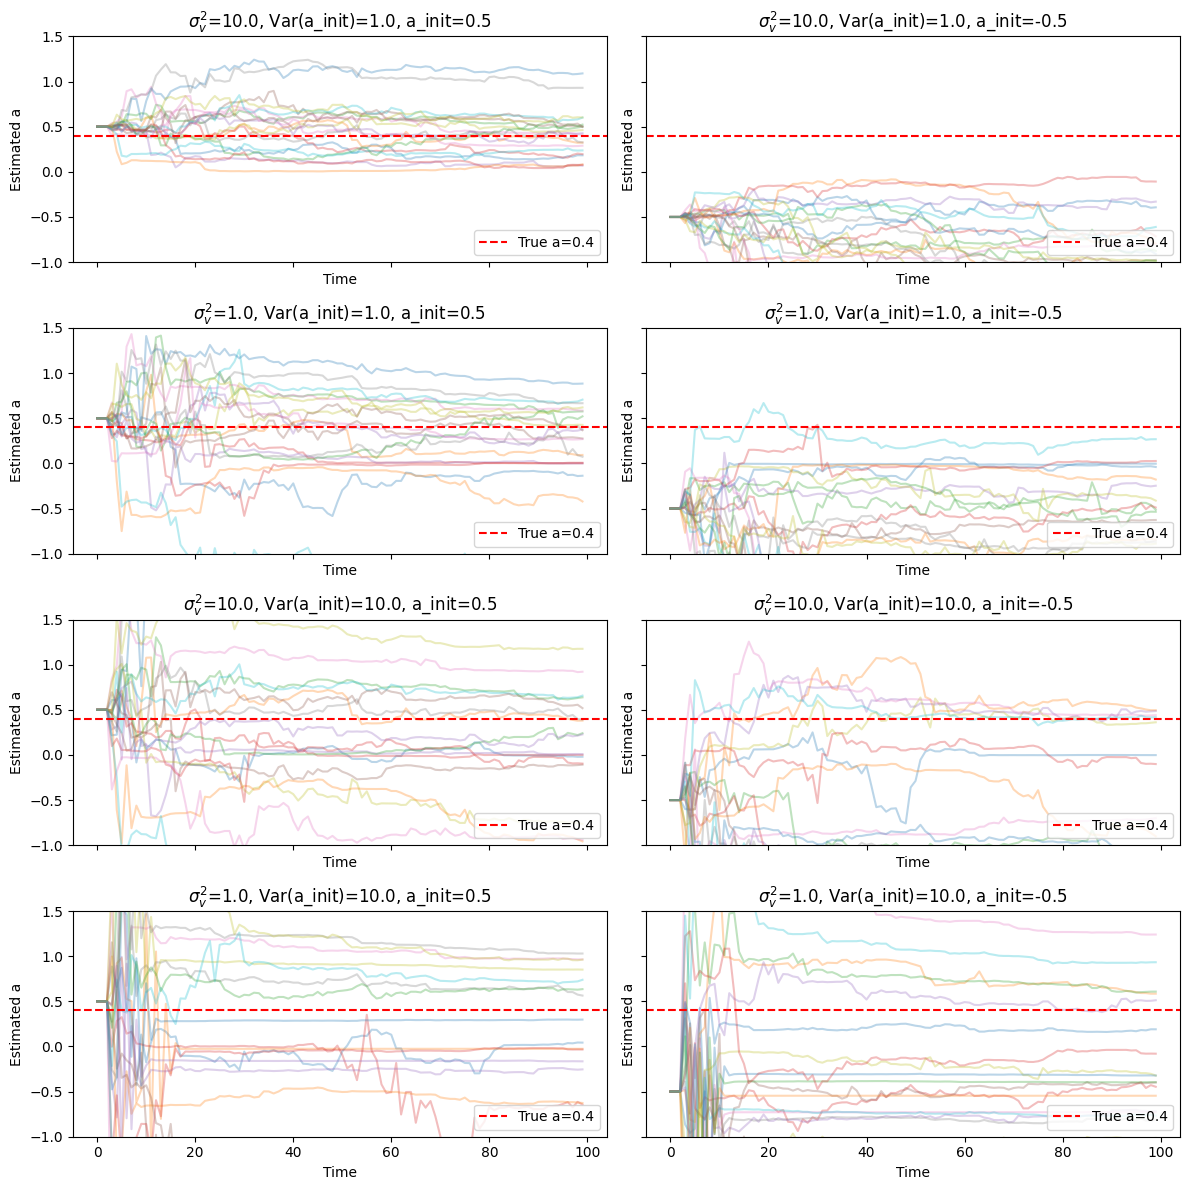

In [7]:
from src.utils.ekg import ekf_parameter_estimation

# Combinations as specified
combinations = [
    {'sigma_v2': 10.0, 'a_var_init': 1.0},
    {'sigma_v2': 1.0, 'a_var_init': 1.0},
    {'sigma_v2': 10.0, 'a_var_init': 10.0},
    {'sigma_v2': 1.0, 'a_var_init': 10.0},
]
a_inits = [0.5, -0.5]
sigma_e2 = 1.0

# Plot estimates for each combination and initial a
fig, axs = plt.subplots(len(combinations), len(a_inits), figsize=(12, 12), sharex=True, sharey=True)
for i, combo in enumerate(combinations):
    for j, a_init in enumerate(a_inits):
        ax = axs[i, j]
        for y in simulations:
            z, avar = ekf_parameter_estimation(y, a_init=a_init, a_var_init=combo['a_var_init'], sigma_v2=combo['sigma_v2'], sigma_e2=sigma_e2)
            ax.plot(z[:, 1], alpha=0.3)
        ax.axhline(a_true, color='red', linestyle='--', label='True a=0.4')
        ax.set_title(fr"$\sigma_v^2$={combo['sigma_v2']}, Var(a_init)={combo['a_var_init']}, a_init={a_init}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Estimated a')
        ax.legend(loc='lower right')
        ax.set_ylim(-1.0, 1.5)

plt.tight_layout()
plt.savefig('plots/ekf_parameter_estimation.png')
plt.show()

# Discussion: Convergence is faster and more reliable when σ_v² is larger in the filter (allows more adaptation) and when initial variance on a is higher. Negative initial a can lead to slower convergence or temporary bias, especially with small σ_v², as the filter is less aggressive in updating the parameter.

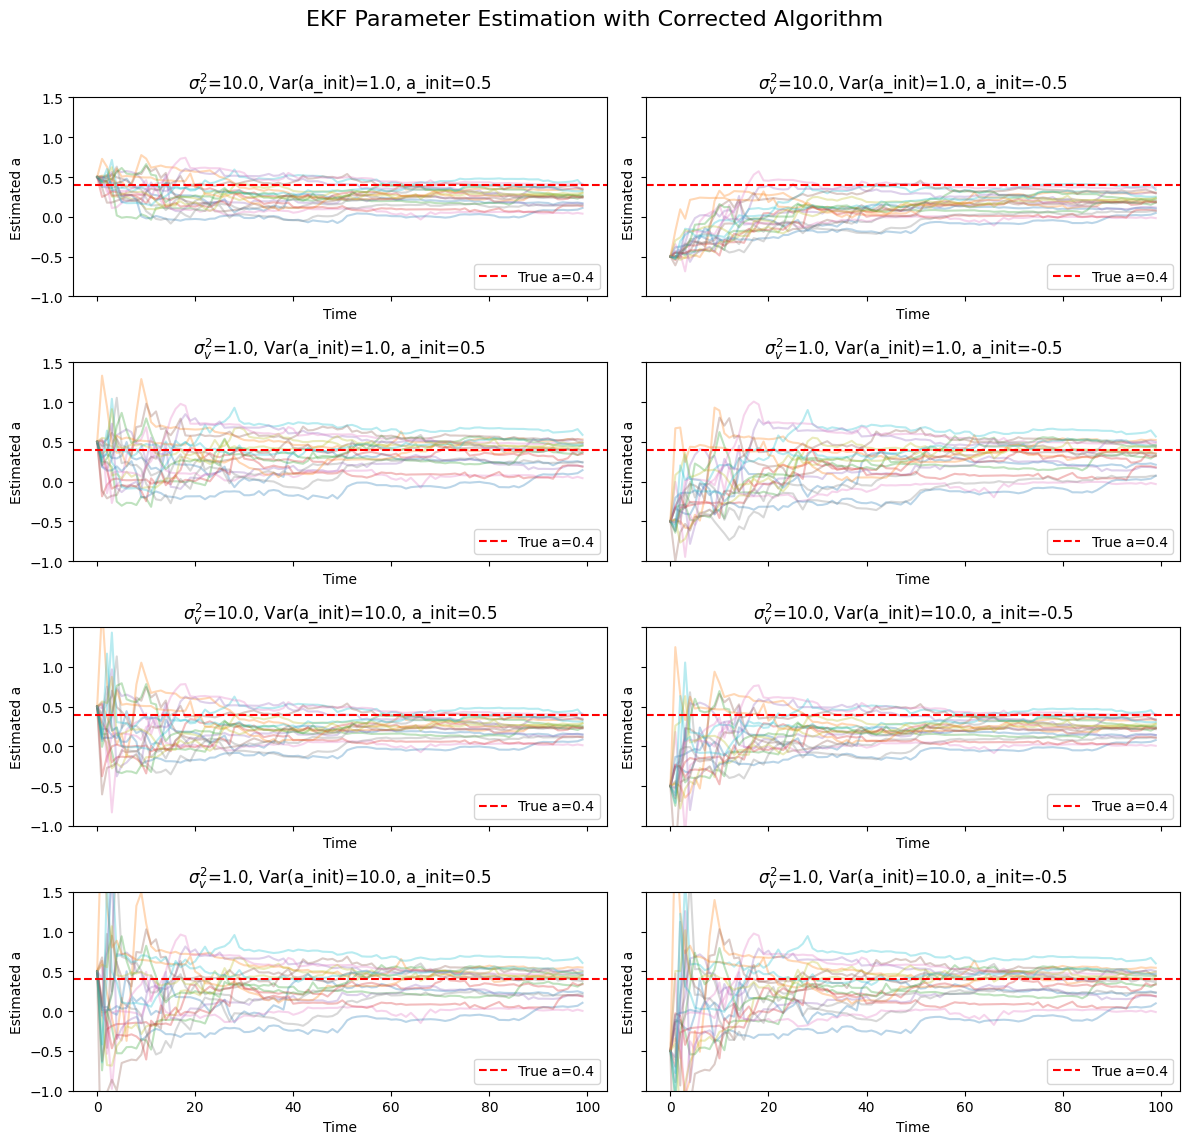

In [8]:
# Gemini

from src.utils.ekg_gemini import ekf_parameter_estimation_corrected

# Combinations as specified
combinations = [
    {'sigma_v2': 10.0, 'a_var_init': 1.0},
    {'sigma_v2': 1.0, 'a_var_init': 1.0},
    {'sigma_v2': 10.0, 'a_var_init': 10.0},
    {'sigma_v2': 1.0, 'a_var_init': 10.0},
]
a_inits = [0.5, -0.5]
sigma_e2 = 1.0

# Plot estimates for each combination and initial a
fig, axs = plt.subplots(len(combinations), len(a_inits), figsize=(12, 12), sharex=True, sharey=True)
fig.suptitle('EKF Parameter Estimation with Corrected Algorithm', fontsize=16)

for i, combo in enumerate(combinations):
    for j, a_init in enumerate(a_inits):
        ax = axs[i, j]
        for y in simulations:
            # Call the corrected EKF function
            z, avar = ekf_parameter_estimation_corrected(y, a_init=a_init, a_var_init=combo['a_var_init'], sigma_v2=combo['sigma_v2'], sigma_e2=sigma_e2)
            ax.plot(z[:, 1], alpha=0.3)
        ax.axhline(a_true, color='red', linestyle='--', label='True a=0.4')
        ax.set_title(fr"$\sigma_v^2$={combo['sigma_v2']}, Var(a_init)={combo['a_var_init']}, a_init={a_init}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Estimated a')
        ax.legend(loc='lower right')
        ax.set_ylim(-1.0, 1.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('plots/ekf_parameter_estimation_gemini.png')
plt.show()